In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("exercise3.csv")
data = data.drop(columns=[data.columns[0]], axis=1)
data.head()

,y_data,x_data
0,-0.486464,0.781001
1,-0.157514,0.096460
2,0.002295,0.566057
3,0.080777,0.288469
4,0.106605,-0.235836


In [3]:
def epanechnikov(u):
    return 0.75*(1-u**2)*(np.abs(u)<=1)

def gaussian(u):
    return np.exp(-u**2/2)/np.sqrt(2*np.pi)

def local_polynomial_regression(x_train, y_train, x_eval, h, p=3, kernel="Epanechnikov"):
    u = x_train - x_eval
    P = np.vander(u, p+1, increasing=True)

    if(kernel == 'Gaussian'):
        W = np.diag(gaussian(u/h))

    else: 
        W = np.diag(epanechnikov(u/h))

    e_hat = np.linalg.inv(P.T @ W @ P) @ (P.T @ W @ y_train)
    return e_hat[0], P, W #husk at man ganger på starten med e_0 = (1, 0, 0, ...)^T!

def LOOCV(x, y, h_arr, kernel="Epanechnikov"): #Leave-one-out CV
    n = len(x)
    CV_scores = np.zeros(len(h_arr))

    for h_idx, h in enumerate(h_arr):
        w_n = np.zeros(n)
        e_hat_arr = np.zeros(n)

        for i in range(n):
            e_hat, P, W = local_polynomial_regression(x, y, x[i], h, p=3, kernel=kernel)
            w_n[i] = (np.linalg.inv(P.T @ W @ P) @ (P.T @ W))[0,i]
            e_hat_arr[i] = e_hat
        
        CV_scores[h_idx] = np.mean(((y - e_hat_arr)/(1 - w_n))**2)
    
    return CV_scores

In [4]:
def true_regression_func(x):
    return 0.3*x**2 - 1.5*x**3 + 0.2*x**4 - 0.002*x**5

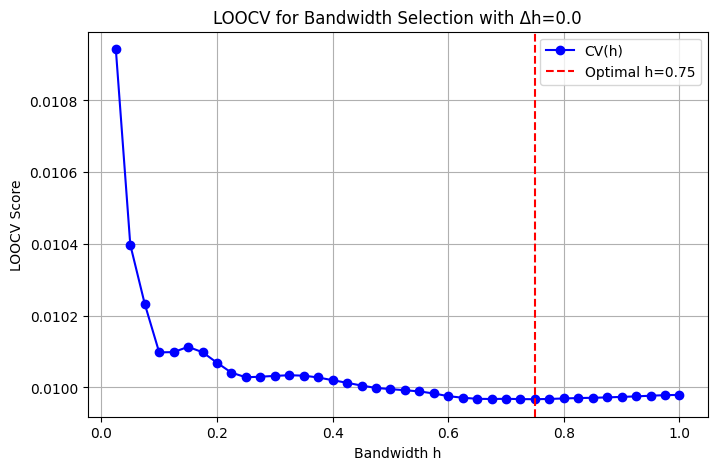

In [6]:
#Part i)
delta = 0.025
epsilon = 10e-6
lower = delta
upper = 1+delta-epsilon
y = data.iloc[:,0].to_numpy()
x = data.iloc[:,1].to_numpy()
h = np.arange(lower, upper, delta)

CV_scores = LOOCV(x, y, h, kernel="Epanechnikov")
h_CV = h[np.argmin(CV_scores)]

plt.figure(figsize=(8, 5))
plt.plot(h, CV_scores, marker='o', linestyle='-', color='b', label="CV(h)")
plt.axvline(h_CV, color='r', linestyle="--", label=f"Optimal h={h_CV:.2f}")
plt.xlabel("Bandwidth h")
plt.ylabel("LOOCV Score")
plt.title(f"LOOCV for Bandwidth Selection with Δh={h[1]-h[0]:.1f}")
plt.legend()
plt.grid()
plt.show()

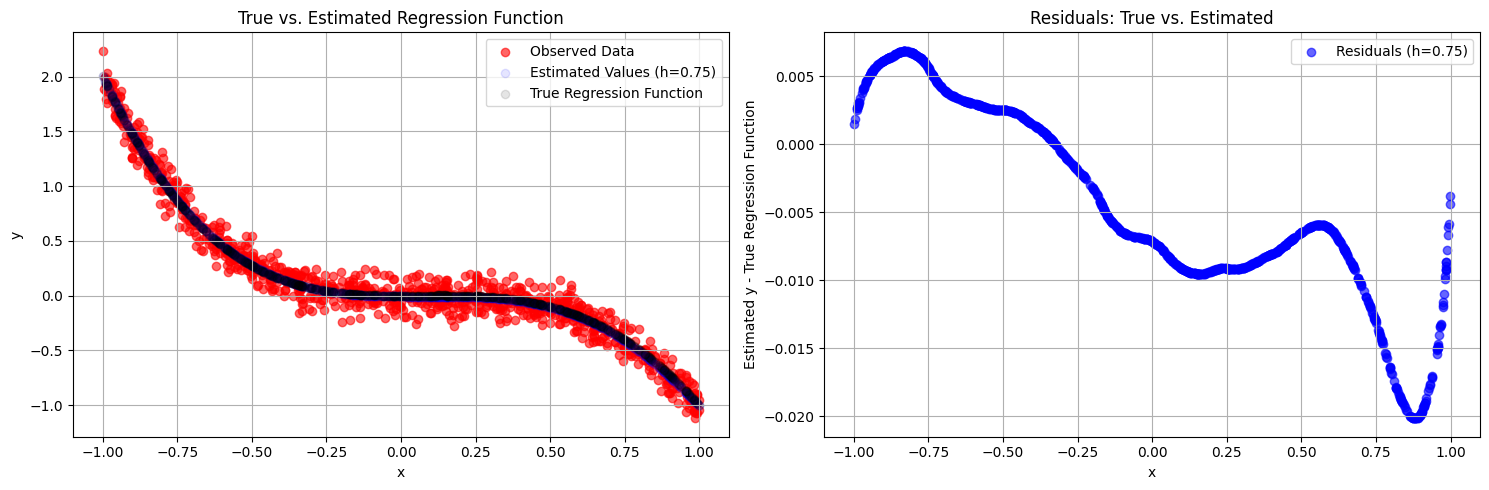

In [7]:
#Part ii)
mu = true_regression_func(x)
y_estimated = np.array([local_polynomial_regression(x, y, x[i], h_CV, p=3)[0] for i in range(len(x))])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))  

axes[0].scatter(x, y, label="Observed Data", color="red", alpha=0.6)
axes[0].scatter(x, y_estimated, label=f"Estimated Values (h={h_CV:.2f})", color="blue", alpha=0.1)
axes[0].scatter(x, mu, label="True Regression Function", color="black", alpha=0.1)
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("True vs. Estimated Regression Function")
axes[0].legend()
axes[0].grid()

axes[1].scatter(x, y_estimated - mu, label=f"Residuals (h={h_CV:.2f})", color="blue", alpha=0.6)
axes[1].set_xlabel("x")
axes[1].set_ylabel("Estimated y - True Regression Function")
axes[1].set_title("Residuals: True vs. Estimated")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()